# Algorithmes itératifs pour les processus de décision Markovien

## Données et Paramètres

In [63]:
import numpy as np

escompte = 0.9  
recompense = np.zeros((3, 4))  
recompense[1, 3] = -1  
recompense[0, 3] = 1  
actions = ["haut", "bas", "gauche", "droite"]
transition_prob = {
    "haut": {"haut": 0.8, "gauche": 0.1, "droite": 0.1},
    "bas": {"bas": 0.8, "gauche": 0.1, "droite": 0.1},
    "gauche": {"gauche": 0.8, "haut": 0.1, "bas": 0.1},
    "droite": {"droite": 0.8, "haut": 0.1, "bas": 0.1},
}

politique = np.full((3, 4), "droite")  
V = np.zeros((3, 4))  
etat_terminaux = [(1, 3), (0, 3), (1, 1)]
obstacle = (1, 1)

def deplacer(x, y, action):
    nouvelle_x, nouvelle_y = x, y
    if action == "haut":
        nouvelle_x = max(x - 1, 0)
    elif action == "bas":
        nouvelle_x = min(x + 1, 2)
    elif action == "gauche":
        nouvelle_y = max(y - 1, 0)
    elif action == "droite":
        nouvelle_y = min(y + 1, 3)

    if (nouvelle_x, nouvelle_y) == (1, 1):
        return x, y  
    return nouvelle_x, nouvelle_y

## Question 1 : Iteration Value

[[ 0.64496924  0.74438015  0.84776628  1.        ]
 [ 0.56631445  0.          0.57185903 -1.        ]
 [ 0.49068396  0.43084445  0.47547113  0.27729583]]
Nombre d'itérations pour converger : 30


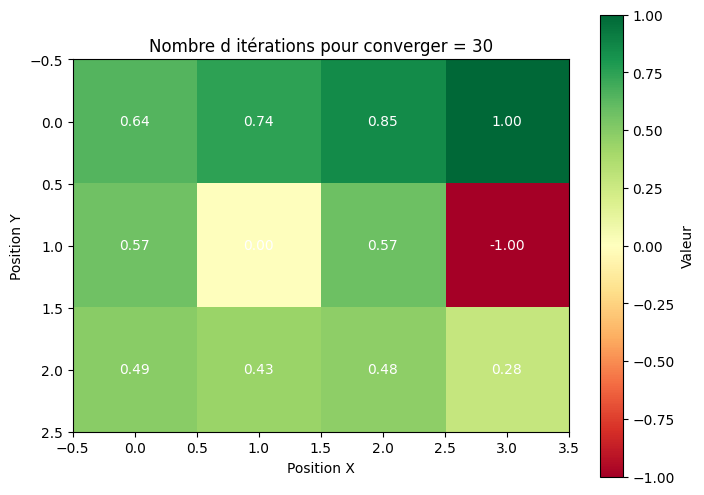

In [64]:
V = np.zeros((3, 4))

def V_Prime(V, recompense, escompte, transition_prob):
    next_V = np.zeros(V.shape)
    for x in range(V.shape[0]):
        for y in range(V.shape[1]):
            if (x, y) in etat_terminaux:
                next_V[x, y] = recompense[x, y]
                continue
            
            valeurs = []
            for action in actions:
                v = 0
                for prochaine_action, prob in transition_prob[action].items():
                    prochaine_x, prochaine_y = deplacer(x, y, prochaine_action)
                    if (prochaine_x, prochaine_y) == (1, 1):
                        continue
                    v += prob * (recompense[x, y] + escompte * V[prochaine_x, prochaine_y])
                valeurs.append(v)
            next_V[x, y] = max(valeurs)
    return next_V

num_iterations = 0
seuil = 1e-8
while True:
    prochaine_V = V_Prime(V, recompense, escompte, transition_prob)
    num_iterations += 1  
    if np.max(np.abs(prochaine_V - V)) < seuil:
        break
    V = prochaine_V

print(V)
print(f"Nombre d'itérations pour converger : {num_iterations}")

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.imshow(V, cmap='RdYlGn', interpolation='nearest')
plt.title(f'Nombre d itérations pour converger = {num_iterations}')
plt.xlabel('Position X')
plt.ylabel('Position Y')

for i in range(V.shape[0]):
    for j in range(V.shape[1]):
        text = plt.text(j, i, f'{V[i, j]:.2f}', ha="center", va="center", color="w")

plt.grid(False)
plt.colorbar(label='Valeur')

plt.show()

## Question 2 : Iteration Policy

In [65]:
def evaluer_politique(V, politique, recompense, escompte, transition_prob):
    while True:
        delta = 0
        for x in range(V.shape[0]):
            for y in range(V.shape[1]):
                if (x, y) in etat_terminaux or (x, y) == obstacle:
                    continue
                v = V[x, y]
                action = politique[x, y]
                V[x, y] = somme_transition(x, y, action, V, recompense, escompte, transition_prob)
                delta = max(delta, abs(v - V[x, y]))
        if delta < 1e-8:
            break
    return V

def ameliorer_politique(V, politique, recompense, escompte, transition_prob):
    politique_stable = True
    for x in range(V.shape[0]):
        for y in range(V.shape[1]):
            if (x, y) in etat_terminaux or (x, y) == obstacle:
                continue
            ancienne_action = politique[x, y]
            valeurs = []
            for action in actions:
                valeur_action = somme_transition(x, y, action, V, recompense, escompte, transition_prob)
                valeurs.append(valeur_action)
            meilleure_action = actions[np.argmax(valeurs)]
            politique[x, y] = meilleure_action
            if ancienne_action != meilleure_action:
                politique_stable = False
    return politique, politique_stable

def somme_transition(x, y, action, V, recompense, escompte, transition_prob):
    somme = 0
    for prochaine_action, prob in transition_prob[action].items():
        prochaine_x, prochaine_y = deplacer(x, y, prochaine_action)
        somme += prob * (recompense[prochaine_x, prochaine_y] + escompte * V[prochaine_x, prochaine_y])
    return somme

num_iterations = 0
while True:
    V = evaluer_politique(V, politique, recompense, escompte, transition_prob)
    politique, politique_stable = ameliorer_politique(V, politique, recompense, escompte, transition_prob)
    num_iterations += 1
    if politique_stable:
        break

politique[1, 3] = 'loss'
politique[0, 3] = 'win'
politique[obstacle] = 'wall'

print("Politique optimale:")
print(politique)
print(f"Politique optimale atteint après {num_iterations} itérations")

Politique optimale:
[['droite' 'droite' 'droite' 'win']
 ['haut' 'wall' 'haut' 'loss']
 ['haut' 'gauche' 'haut' 'gauche']]
Politique optimale atteint après 3 itérations
